# Importing the packages

In [86]:
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from numpy import array
import gensim
import sklearn.metrics as metrics

# Importing Data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Findings about the Data

In [3]:
train_data.shape

(20800, 5)

In [4]:
train_data.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

Issues with null values can pose problems so removing text and title makes the best option. Experiments done by predicting author and without predicting author.

In [5]:
train_data = train_data[train_data['text'].notnull()]
train_data = train_data[train_data['title'].notnull()]
train_data.shape

(20203, 5)

In [6]:
train_data = train_data.reset_index().drop(['index','id'],axis=1)

In [7]:
#Cleaning the data using lemmatizer and other preprocessing
def textClean(text):
    lemma = WordNetLemmatizer()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [lemma.lemmatize(word).lower() for word in tokens if word.lower() not in stop_words]
    return re.sub("\s\s+" , " ", ' '.join(words))

In [8]:
for i in range(len(train_data)):
        train_data.loc[i, 'text'] = textClean(train_data.loc[i,'text'])
        train_data.loc[i, 'title'] = textClean(train_data.loc[i,'title'])

# Predicting author

In [12]:
Null_author_data = train_data.loc[train_data['author'].isnull()]
Not_Null_author_data = train_data.loc[train_data['author'].notnull()]

In [13]:
Null_author_data = Null_author_data.reset_index().drop("index",axis=1)

In [14]:
Not_Null_author_data = Not_Null_author_data.reset_index().drop("index",axis=1)

In [15]:
#Converting categorical to numerical values
Not_Null_author_data['category_id'] = Not_Null_author_data['author'].factorize()[0]

In [16]:
#Creating dictionary to revert back to original author values
category_id_df = Not_Null_author_data[['author', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'author']].values)

# Predicting Authors for the Null Values

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(Not_Null_author_data['text'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LinearSVC().fit(X_train_tfidf, Not_Null_author_data['category_id'])

In [18]:
Null_author_data["category_id"] = clf.predict(count_vect.transform(Null_author_data["text"]))

In [19]:
Null_author_data["author"] = Null_author_data["category_id"].map(id_to_category)

In [20]:
full_data = Not_Null_author_data.append(Null_author_data, ignore_index = True).drop("category_id",axis =1)

# Doc2Vec Model and Embeddings

In [23]:
def LabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['row_' + str(index)]))
    return sentences

In [24]:
X = LabeledSentences(full_data['text'])
y = full_data['label']

In [28]:
# http://linanqiu.github.io/2015/10/07/word2vec-sentiment/
model = gensim.models.Doc2Vec(vector_size=300, window=5, min_count=1, workers=9,
                              alpha=0.025, min_alpha=0.025, epochs=20, sample=1e-4)
model.build_vocab(X)
model.train(X, epochs=model.epochs, total_examples=model.corpus_count)

In [32]:
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

train_text = np.zeros((train_size, 300))
test_text = np.zeros((test_size, 300))
train_labels = np.zeros(train_size)
test_labels = np.zeros(test_size)

for i in range(train_size):
    train_text[i] = model.docvecs['row_' + str(i)]
    train_labels[i] = y[i]

j = 0
for i in range(train_size, train_size + test_size):
    test_text[j] = model.docvecs['row_' + str(i)]
    test_labels[j] = y[i]
    j = j + 1

# SVM

In [62]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_text, train_labels)
y_pred = svm.predict(test_text)

Accuracy = 80.97%


In [88]:
print("Accuracy",metrics.accuracy_score(test_labels, y_pred))
print("Precision",metrics.precision_score(test_labels, y_pred))
print("Recall",metrics.recall_score(test_labels, y_pred))
print("F1-score",metrics.f1_score(test_labels, y_pred))

Accuracy 0.809700569166
Precision 0.959982214317
Recall 0.760747004933
F1-score 0.848830351877


# Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_text, train_labels)
y_pred_gnb = gnb.predict(test_text)

Accuracy = 72.19%


In [89]:
print("Accuracy",metrics.accuracy_score(test_labels, y_pred_gnb))
print("Precision",metrics.precision_score(test_labels, y_pred_gnb))
print("Recall",metrics.recall_score(test_labels, y_pred_gnb))
print("F1-score",metrics.f1_score(test_labels, y_pred_gnb))

Accuracy 0.721851026974
Precision 0.843349358974
Recall 0.741719520789
F1-score 0.789276340457


# Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(train_text, train_labels)
y_pred_lr = lr.predict(test_text)

Accuracy = 78.74%


In [90]:
print("Accuracy",metrics.accuracy_score(test_labels, y_pred_lr))
print("Precision",metrics.precision_score(test_labels, y_pred_lr))
print("Recall",metrics.recall_score(test_labels, y_pred_lr))
print("F1-score",metrics.f1_score(test_labels, y_pred_lr))

Accuracy 0.787428854244
Precision 0.949160236042
Recall 0.736786469345
F1-score 0.829597302123


# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0).fit(train_text, train_labels)
y_pred_rfc = lr.predict(test_text)

Accuracy = 78.74%


In [91]:
print("Accuracy",metrics.accuracy_score(test_labels, y_pred_rfc))
print("Precision",metrics.precision_score(test_labels, y_pred_rfc))
print("Recall",metrics.recall_score(test_labels, y_pred_rfc))
print("F1-score",metrics.f1_score(test_labels, y_pred_rfc))

Accuracy 0.787428854244
Precision 0.949160236042
Recall 0.736786469345
F1-score 0.829597302123


# Confusion Matrix

In [58]:
# Code acquired from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_cf(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
def plot_confusion_matrix(yte, ypred):
    cnf_matrix = confusion_matrix(yte, ypred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = [0,1]
    plot_cf(cnf_matrix, classes=class_names,title='Confusion Matrix')
    plt.show()

Confusion matrix, without normalization
[[1113   90]
 [ 679 2159]]


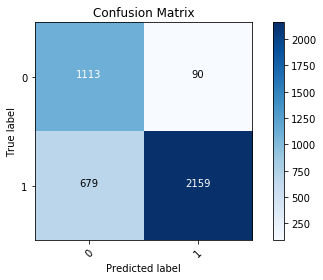

In [63]:
#SVM
plot_confusion_matrix(test_labels,y_pred)

Confusion matrix, without normalization
[[ 812  391]
 [ 733 2105]]


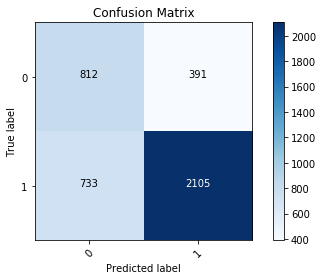

In [61]:
# Naive Bayes
plot_confusion_matrix(test_labels,y_pred_gnb)

Confusion matrix, without normalization
[[1091  112]
 [ 747 2091]]


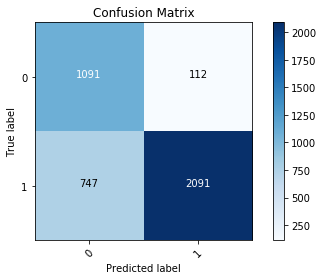

In [64]:
# Logistic Regression
plot_confusion_matrix(test_labels,y_pred_lr)

Confusion matrix, without normalization
[[1091  112]
 [ 747 2091]]


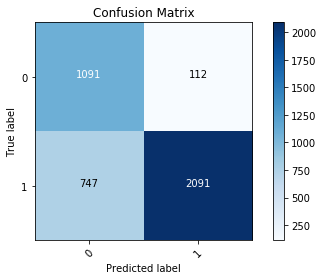

In [65]:
# Random Forest
plot_confusion_matrix(test_labels,y_pred_rfc)

# Testing on Another Dataset

In [97]:
# https://github.com/GeorgeMcIntire/fake_real_news_dataset
new_test_df = pd.read_csv("fake_or_real_news.csv")
new_test_df.drop("Unnamed: 0", axis = 1, inplace= True)

In [98]:
fake_real = {'FAKE': 0, 'REAL':1}
new_test_df['label'] = new_test_df['label'].map(fake_real)

In [99]:
new_test_df = new_test_df[new_test_df['text'].notnull()]
new_test_df = new_test_df.reset_index().drop(['index'],axis=1)

In [100]:
for i in range(len(new_test_df)):
        new_test_df.loc[i, 'text'] = textClean(new_test_df.loc[i,'text'])

In [101]:
X_test_tagged = LabeledSentences(new_test_df["text"])
y_test = new_test_df["label"]

In [102]:
model = gensim.models.Doc2Vec(vector_size=300, window=5, min_count=1, workers=9,
                              alpha=0.025, min_alpha=0.025, epochs=20, sample=1e-4)
model.build_vocab(X_test_tagged)
model.train(X_test_tagged, epochs=model.epochs, total_examples=model.corpus_count)

In [103]:
train_text_test = np.zeros((len(X_test_tagged), 300))
train_labels_test = np.zeros(len(X_test_tagged))

for i in range(len(X_test_tagged)):
    train_text_test[i] = model.docvecs['row_' + str(i)]
    train_labels_test[i] = y_test[i]

In [104]:
y_pred_test_data = svm.predict(train_text_test)

In [105]:
print("Accuracy",metrics.accuracy_score(train_labels_test, y_pred_test_data))
print("Precision",metrics.precision_score(train_labels_test, y_pred_test_data))
print("Recall",metrics.recall_score(train_labels_test, y_pred_test_data))
print("F1-score",metrics.f1_score(train_labels_test, y_pred_test_data))

Accuracy 0.319021310182
Precision 0.378996400593
Recall 0.564490696941
F1-score 0.453508994173


In [106]:
y_pred_gnb_test_data = gnb.predict(train_text_test)

In [107]:
print("Accuracy",metrics.accuracy_score(train_labels_test, y_pred_gnb_test_data))
print("Precision",metrics.precision_score(train_labels_test, y_pred_gnb_test_data))
print("Recall",metrics.recall_score(train_labels_test, y_pred_gnb_test_data))
print("F1-score",metrics.f1_score(train_labels_test, y_pred_gnb_test_data))

Accuracy 0.398421468035
Precision 0.417483238783
Recall 0.510564490697
F1-score 0.459355937012


In [108]:
y_pred_lr_test_data = lr.predict(train_text_test)

In [109]:
print("Accuracy",metrics.accuracy_score(train_labels_test, y_pred_lr_test_data))
print("Precision",metrics.precision_score(train_labels_test, y_pred_lr_test_data))
print("Recall",metrics.recall_score(train_labels_test, y_pred_lr_test_data))
print("F1-score",metrics.f1_score(train_labels_test, y_pred_lr_test_data))

Accuracy 0.351223362273
Precision 0.409694171956
Recall 0.671712393567
F1-score 0.508960573477


In [110]:
y_pred_rfc_test_data = lr.predict(train_text_test)

In [111]:
print("Accuracy",metrics.accuracy_score(train_labels_test, y_pred_rfc_test_data))
print("Precision",metrics.precision_score(train_labels_test, y_pred_rfc_test_data))
print("Recall",metrics.recall_score(train_labels_test, y_pred_rfc_test_data))
print("F1-score",metrics.f1_score(train_labels_test, y_pred_rfc_test_data))

Accuracy 0.351223362273
Precision 0.409694171956
Recall 0.671712393567
F1-score 0.508960573477


Confusion matrix, without normalization
[[ 231 2933]
 [1381 1790]]


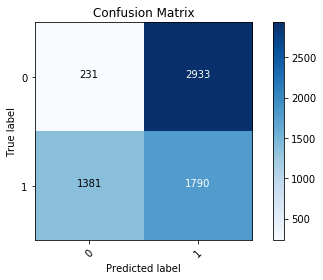

In [112]:
plot_confusion_matrix(train_labels_test,y_pred_test_data)

Confusion matrix, without normalization
[[ 905 2259]
 [1552 1619]]


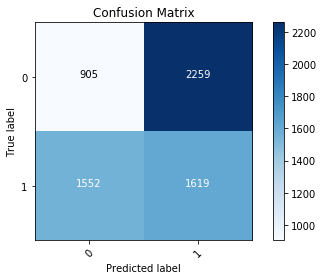

In [113]:
plot_confusion_matrix(train_labels_test,y_pred_gnb_test_data)

Confusion matrix, without normalization
[[  95 3069]
 [1041 2130]]


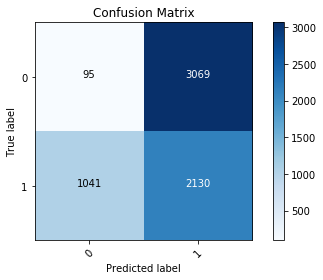

In [114]:
plot_confusion_matrix(train_labels_test,y_pred_lr_test_data)

Confusion matrix, without normalization
[[  95 3069]
 [1041 2130]]


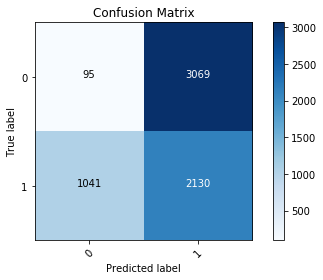

In [115]:
plot_confusion_matrix(train_labels_test,y_pred_rfc_test_data)